In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering


In [6]:
df = pd.read_csv('model data.csv')

In [7]:
df.diagnosis.unique()

array(['SAOS', 'REM Sleep Behaviour Disorder', 'SRVAS', 'PLMS',
       'D. Afectiva', 'RONCOPATIA', 'EPILEPSIA', 'S. PERNAS INQUIETAS',
       'PRIVAÇÃO DE SONO', 'Parasomnia ', 'no problem', 'F'], dtype=object)

In [8]:
# RONCOPATIA = snoring
# S. PERNAS INQUIETAS = restless leg syndrome
# SAOS = sleep apnea
# PLMS = Periodic limb movements of sleep
# EPILEPSIA = epilepsy
# PRIVAÇÃO DE SONO = sleep deprivation
## SRVAS, D.Afectiva

In [9]:
df['diagnosis'] = np.where(df.diagnosis=='F', None, df.diagnosis)

In [10]:
df.diagnosis.unique().size

12

In [11]:
#1hot encoding for gender
df['is_male'] = df.sex.str.lower() == "m"
df['is_female'] = df.sex.str.lower() == "f"
df.head()

,recording,Source,age,sex,diagnosis,other problems,epoches,w%,n1%,n2%,n3%,rem%,is_male,is_female
0,1,isruc-1,64.0,M,SAOS,Depression,880.0,30.00,8.30,22.05,26.25,13.41,True,False
1,2,isruc-1,52.0,M,SAOS,Restless leg syndrome,964.0,25.41,11.93,35.79,16.29,10.58,True,False
2,3,isruc-1,38.0,M,REM Sleep Behaviour Disorder,PLMS,943.0,14.00,17.50,26.09,18.35,24.07,True,False
3,4,isruc-1,27.0,M,SRVAS,Epilepsy,963.0,2.91,6.75,44.24,22.22,23.88,True,False
4,5,isruc-1,58.0,F,SAOS,Insomnia,875.0,33.83,12.34,30.29,18.74,4.80,False,True


In [12]:
df.groupby('diagnosis').count()['Source'].sort_values()

diagnosis
SRVAS                            1
EPILEPSIA                        2
PLMS                             2
Parasomnia                       2
REM Sleep Behaviour Disorder     2
S. PERNAS INQUIETAS              2
PRIVAÇÃO DE SONO                 3
D. Afectiva                      8
no problem                      10
RONCOPATIA                      18
SAOS                            76
Name: Source, dtype: int64

In [13]:
df = df.dropna(subset=['w%','n1%', 'n2%', 'n3%', 'rem%', 'age', 'sex', 'diagnosis'])

In [14]:
df.diagnosis.unique()

array(['SAOS', 'REM Sleep Behaviour Disorder', 'SRVAS', 'PLMS',
       'D. Afectiva', 'RONCOPATIA', 'EPILEPSIA', 'S. PERNAS INQUIETAS',
       'PRIVAÇÃO DE SONO', 'Parasomnia ', 'no problem'], dtype=object)

In [15]:
from sklearn.model_selection import train_test_split

X = df[['w%','n1%', 'n2%', 'n3%', 'rem%']] #'age', 'is_male', 'is_female']]
y = df[['diagnosis']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [17]:
y_train

,diagnosis
55,RONCOPATIA
9,SAOS
33,SAOS
62,SAOS
25,SAOS
...,...
108,SAOS
14,SAOS
93,SAOS
51,RONCOPATIA


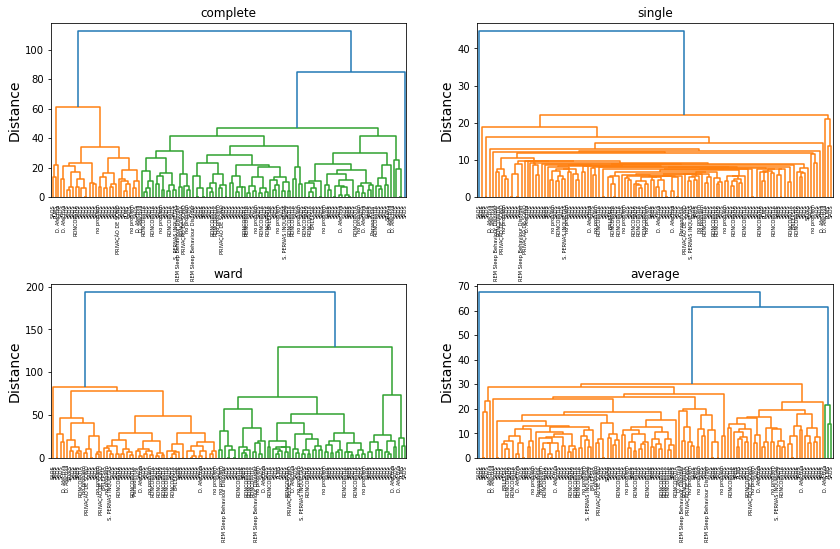

In [18]:
methods = ['complete', 'single', 'ward', 'average']
plt.figure(figsize=(14, 8))
for index, method in enumerate(methods):
    plt.subplot(2, 2, index + 1)
    den = dendrogram(linkage(X, method=method, optimal_ordering=True), 
    show_leaf_counts=False,
    labels=y.diagnosis.to_list()
                    )
    plt.ylabel('Distance', fontsize = 14)
    plt.title(method)
    plt.subplots_adjust(hspace=0.5)

plt.show()


In [19]:
cluster_results = X.copy()
cluster_results['diagnosis'] = y.copy()
nclusters = df.diagnosis.unique().size
metrics_arr = []
for index, linkage in enumerate(methods):
    model = AgglomerativeClustering(linkage=linkage, n_clusters=nclusters)
    cluster_results[linkage] = model.fit_predict(X)
    metrics_arr.append({'linkage':linkage, 
                        'sillhouette score': metrics.silhouette_score(X, model.labels_, metric='euclidean'),
                       'calinski harabasz score': metrics.calinski_harabasz_score(X, model.labels_),
                       'davies bouldin score': metrics.davies_bouldin_score(X,model.labels_),
                       })

In [20]:
pd.DataFrame(metrics_arr).T

,0,1,2,3
linkage,complete,single,ward,average
sillhouette score,0.187151,-0.0694053,0.209581,0.161363
calinski harabasz score,39.8279,6.9325,44.7054,26.5656
davies bouldin score,1.13094,0.482244,1.14608,0.682983


In [21]:
cluster_results['count'] = 1


In [22]:
dfs = []
for linkage in methods:
    x = cluster_results.groupby([linkage,'diagnosis'],as_index=False).agg({linkage:'first',f'diagnosis':'first', 'count':'count'}).sort_values(by=[linkage,'count'],ascending=False).groupby(linkage).agg({f'diagnosis':'first','count':'first'}).rename(columns={'diagnosis':linkage+'-most common diagnosis','count':linkage+'-diagnosis count'})
    dfs.append(x)

pd.concat([x.T for x in dfs]).T


,complete-most common diagnosis,complete-diagnosis count,single-most common diagnosis,single-diagnosis count,ward-most common diagnosis,ward-diagnosis count,average-most common diagnosis,average-diagnosis count
0,SAOS,21,SAOS,70,SAOS,12,SAOS,8
1,SAOS,7,SAOS,1,SAOS,6,SAOS,3
2,SAOS,10,SAOS,2,RONCOPATIA,4,SAOS,23
3,SAOS,11,D. Afectiva,1,SAOS,5,SAOS,1
4,SAOS,16,SAOS,1,SAOS,11,SAOS,38
5,SAOS,1,SAOS,1,D. Afectiva,1,SAOS,1
6,SAOS,3,D. Afectiva,1,SAOS,10,PLMS,1
7,SAOS,2,PLMS,1,SAOS,1,D. Afectiva,1
8,D. Afectiva,1,D. Afectiva,1,SAOS,11,D. Afectiva,1
9,PRIVAÇÃO DE SONO,1,SAOS,1,SAOS,13,SAOS,1
